In [1]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# rock_paper_scissors 데이터셋 다운로드 , Windows용
_TRAIN_URL = "https://storage.googleapis.com/learning-datasets/rps.zip"
_TEST_URL = "https://storage.googleapis.com/learning-datasets/rps-test-set.zip"
urllib.request.urlretrieve(_TRAIN_URL, 'tmp/rps.zip')
urllib.request.urlretrieve(_TEST_URL, 'tmp/rps-test-set.zip')

('tmp/rps-test-set.zip', <http.client.HTTPMessage at 0x20e0e06f4f0>)

In [3]:
# 압축해제
local_zip = 'tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('tmp/')
zip_ref.close()

local_zip = 'tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('tmp/')
zip_ref.close()

In [11]:
# 이미지 데이터 경로 설정
import os

train_dir = os.path.join('tmp/rps')
validation_dir = os.path.join('tmp/rps-test-set')

# Directory with our training rock pictures
train_rock_dir = os.path.join('tmp/rps/rock')
# Directory with our training paper pictures
train_paper_dir = os.path.join('tmp/rps/paper')
# Directory with our training scissors pictures
train_scissors_dir = os.path.join('tmp/rps/scissors')

# Directory with our training rock pictures
validation_rock_dir = os.path.join('tmp/rps-test-set/rock')
# Directory with our training paper pictures
validation_paper_dir = os.path.join('tmp/rps-test-set/paper')
# Directory with our training scissors pictures
validation_scissors_dir = os.path.join('tmp/rps-test-set/scissors')

train_rock_fnames = os.listdir(train_rock_dir)
# print(train_rock_names[:10])
train_paper_fnames = os.listdir(train_paper_dir)
# print(train_paper_names[:10])
train_scissors_fnames = os.listdir(train_scissors_dir)
# print(train_scissors_names[:10])

validation_rock_fnames = os.listdir(validation_rock_dir)
# print(validation_rock_names[:10])
validation_paper_fnames = os.listdir(validation_paper_dir)
# print(validation_paper_names[:10])
validation_scissors_fnames = os.listdir(validation_scissors_dir)
# print(validation_scissors_names[:10])



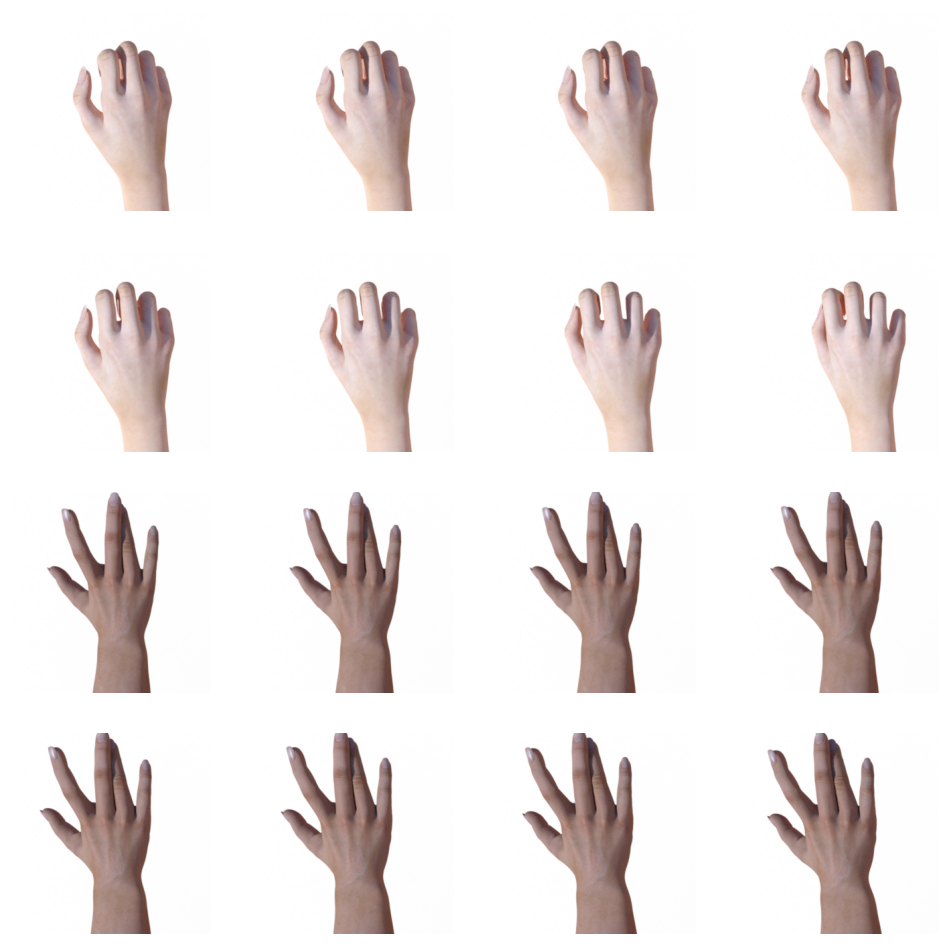

In [12]:
# 데이터 시각화
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images ,시작 인덱스

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=8

next_rock_pix = [os.path.join(train_rock_dir, fname) 
                for fname in train_rock_fnames[ pic_index-8:pic_index] 
               ]
next_paper_pix = [os.path.join(train_paper_dir, fname) 
                for fname in train_paper_fnames[ pic_index-8:pic_index]
               ]
next_scissors_pix = [os.path.join(train_scissors_dir, fname) 
                for fname in train_scissors_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_rock_pix+next_paper_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

### CNN 모델

In [21]:
# 모델 구현
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax')    
])

#  RMSprop, Learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 64)      

### 데이터 전처리 : 이미지 증강

In [22]:
train_datagen = ImageDataGenerator(rescale=1./255)
type(train_datagen)

validation_datagen = ImageDataGenerator(rescale=1./255)

# train data의 generator
train_generator = train_datagen.flow_from_directory(
                  train_dir, # 이미지 파일 디렉터리 경로
                  target_size=(150,150),
                  batch_size=20,
                  class_mode='categorical') # 다중 분류

# validation data의 generator

validation_generator = validation_datagen.flow_from_directory(
                  validation_dir, # 이미지 파일 디렉터리 경로
                  target_size=(150,150),
                  batch_size=20,
                  class_mode='categorical') # 다중 분류

print(train_generator)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [23]:
# 학습
history = model.fit(
            train_generator, # X
            steps_per_epoch=126, # 2520(train image number)/20(train batch_size) 생략해도 자동으로 내부에서 계산
            epochs = 15,
            validation_data=validation_generator,
            validation_steps=18) #372/20

Epoch 1/15
126/126 [==============================] - 6s 37ms/step - loss: 0.3749 - accuracy: 0.8583 - val_loss: 0.6094 - val_accuracy: 0.8056
Epoch 2/15
126/126 [==============================] - 5s 37ms/step - loss: 0.0240 - accuracy: 0.9948 - val_loss: 0.7497 - val_accuracy: 0.7667
Epoch 3/15
126/126 [==============================] - 5s 37ms/step - loss: 7.2195e-04 - accuracy: 1.0000 - val_loss: 0.7294 - val_accuracy: 0.8111
Epoch 4/15
126/126 [==============================] - 5s 37ms/step - loss: 1.4489e-04 - accuracy: 1.0000 - val_loss: 0.7702 - val_accuracy: 0.8028
Epoch 5/15
126/126 [==============================] - 5s 36ms/step - loss: 8.1337e-05 - accuracy: 1.0000 - val_loss: 0.8139 - val_accuracy: 0.8056
Epoch 6/15
126/126 [==============================] - 5s 36ms/step - loss: 5.3070e-05 - accuracy: 1.0000 - val_loss: 0.8335 - val_accuracy: 0.8028
Epoch 7/15
126/126 [==============================] - 5s 37ms/step - loss: 3.8907e-05 - accuracy: 1.0000 - val_loss: 0.8736 - 

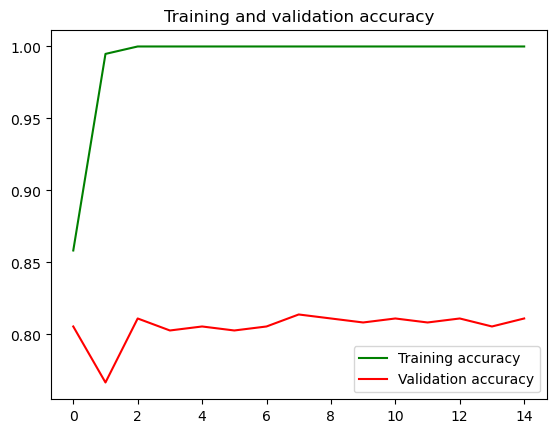

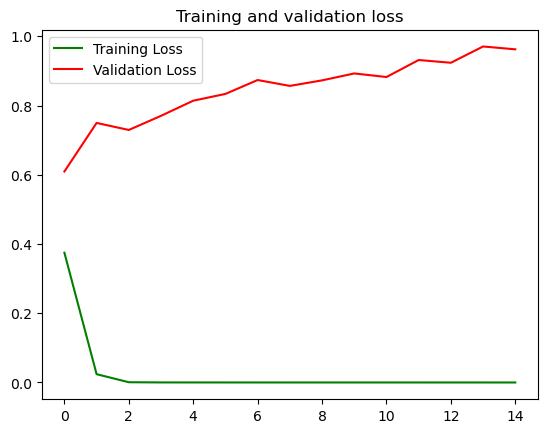

In [24]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()